In [16]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torchvision.transforms as transforms
from torchvision import models
from tqdm import tqdm

In [ ]:
"C:/Users/sanke/OneDrive/Desktop/MAJOR Projects/Stray Aid/The Stray help/all-data"

In [22]:
DATASET_PATH = "C:/Users/sanke/OneDrive/Desktop/MAJOR Projects/Stray Aid/The Stray help/all-data"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
TEST_PATH = os.path.join(DATASET_PATH, "test")

In [23]:
# Load pre-trained model (ResNet-50) for feature extraction
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove last FC layer
resnet.eval()

c:\Users\sanke\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sanke\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [24]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [25]:
def extract_features(image_paths):
    features = []
    valid_images = []
    for img_path in tqdm(image_paths):
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Skipping unreadable image: {img_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = transform(transforms.ToPILImage()(img)).unsqueeze(0)
            
            with torch.no_grad():
                feature = resnet(img).squeeze().numpy()
            features.append(feature.flatten())
            valid_images.append(img_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    return np.array(features), valid_images

In [26]:
train_images = [os.path.join(TRAIN_PATH, img) for img in os.listdir(TRAIN_PATH)]
test_images = [os.path.join(TEST_PATH, img) for img in os.listdir(TEST_PATH)]

In [27]:
# Extract features
train_features, train_images = extract_features(train_images)
test_features, test_images = extract_features(test_images)

100%|██████████| 410/410 [01:07<00:00,  6.11it/s]


In [28]:
# Apply K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(train_features)
train_labels = kmeans.predict(train_features)
test_labels = kmeans.predict(test_features)

In [29]:
# Visualize results
def visualize_clusters(images, labels, title):
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        img = cv2.imread(images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(f"Cluster: {labels[i]}")
        ax.axis("off")
    plt.suptitle(title)
    plt.show()

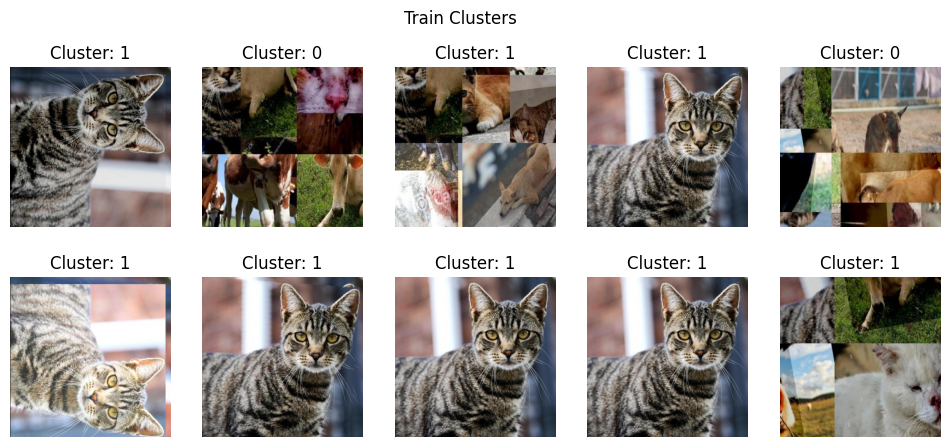

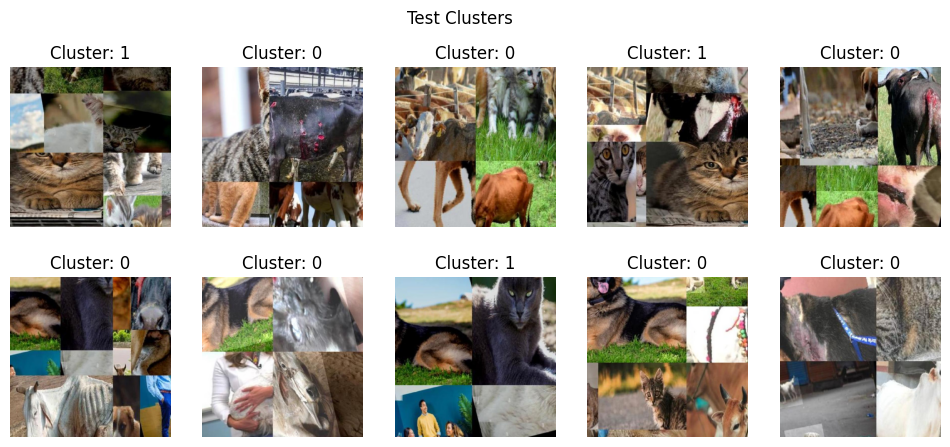

In [30]:
visualize_clusters(train_images, train_labels, "Train Clusters")
visualize_clusters(test_images, test_labels, "Test Clusters")

In [31]:
# Map cluster labels to Injured/Not Injured based on average pixel intensity
injured_cluster = 0 if np.mean(train_features[train_labels == 0]) > np.mean(train_features[train_labels == 1]) else 1
train_labels = np.array([0 if lbl == injured_cluster else 1 for lbl in train_labels])
test_labels = np.array([0 if lbl == injured_cluster else 1 for lbl in test_labels])

In [32]:
# Train an SVM Classifier
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_val)
print(f"SVM Accuracy: {accuracy_score(y_val, y_pred) * 100:.2f}%")

SVM Accuracy: 98.12%


In [33]:
# Prediction function
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = transform(transforms.ToPILImage()(img)).unsqueeze(0)
    
    with torch.no_grad():
        feature = resnet(img).squeeze().numpy().flatten()
    
    prediction = svm_model.predict([feature])[0]
    return "Injured" if prediction == 1 else "Not Injured"

In [42]:
def show_prediction(image_path):
    prediction = predict_image(image_path)  # Get prediction
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Show image with prediction title
    plt.imshow(img)
    plt.title(f"Prediction: {prediction}", fontsize=14, color='black')
    plt.axis("off")
    plt.show()


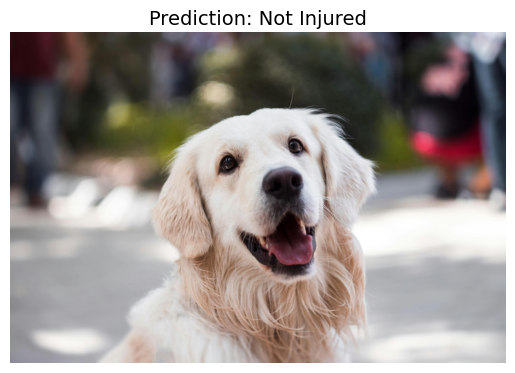

In [43]:
show_prediction("C:/Users/sanke/OneDrive/Desktop/MAJOR Projects/Stray Aid/The Stray help/ML/images/dog.jpg")

In [38]:
import joblib

# Save the trained SVM model
joblib.dump(svm_model, "injury_classification_svm.pkl")
print("Model saved successfully!")


Model saved successfully!


In [5]:
import joblib
model=joblib.load("injury_classification_svm.pkl")
print("model imported successfully")

model imported successfully


In [40]:
predict_image("C:/Users/sanke/OneDrive/Desktop/MAJOR Projects/Stray Aid/The Stray help/ML/images/cat2.webp")

'Injured'

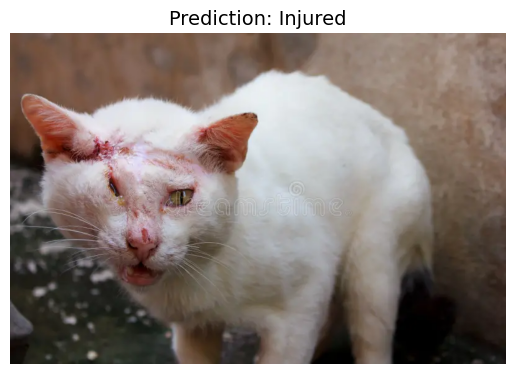

In [45]:
show_prediction("C:/Users/sanke/OneDrive/Desktop/MAJOR Projects/Stray Aid/The Stray help/ML/images/cat2.webp")